Synthetic dataset created at medical_mask_dataset
Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 681ms/step - accuracy: 0.5191 - loss: 0.8457 - val_accuracy: 0.5000 - val_loss: 0.7554
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 446ms/step - accuracy: 0.4567 - loss: 0.7584 - val_accuracy: 0.5500 - val_loss: 0.6933
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - accuracy: 0.4643 - loss: 0.6963 - val_accuracy: 0.5000 - val_loss: 0.7073
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.4896 - loss: 0.7075 - val_accuracy: 0.5000 - val_loss: 0.7179
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.5304 - loss: 0.6966 - val_accuracy: 0.4750 - val_loss: 0.7075
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.4822 - loss: 0.7137 - val_accuracy: 0.4500 - val_loss: 0.6967
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.4326 - loss: 0.7032 - val_accuracy: 0.5250 - val_

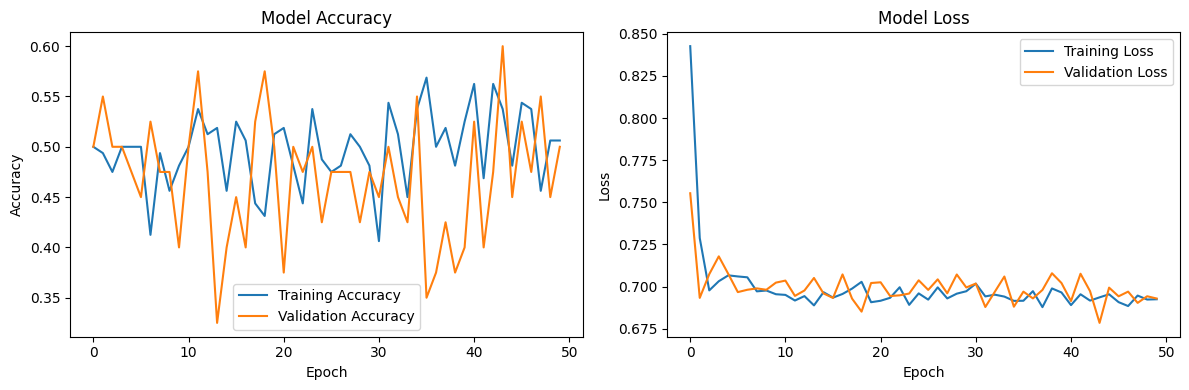

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
Predicted Class: with_mask
Confidence: 99.99%


In [3]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

class MedicalMaskClassifier:
    def __init__(self, img_height=224, img_width=224, num_classes=2):
        """
        Initialize Medical Mask Classification Model

        Args:
            img_height (int): Input image height
            img_width (int): Input image width
            num_classes (int): Number of classification classes
        """
        self.img_height = img_height
        self.img_width = img_width
        self.num_classes = num_classes
        self.model = None

    def generate_synthetic_dataset(self, total_samples=200, dataset_dir='medical_mask_dataset'):
        """
        Generate a synthetic dataset for testing when no real dataset is available

        Args:
            total_samples (int): Total number of synthetic images to generate
            dataset_dir (str): Directory to save synthetic dataset

        Returns:
            str: Path to generated dataset
        """
        # Create dataset directories
        os.makedirs(dataset_dir, exist_ok=True)
        classes = ['with_mask', 'without_mask']

        for cls in classes:
            class_dir = os.path.join(dataset_dir, cls)
            os.makedirs(class_dir, exist_ok=True)

        # Generate synthetic images using random noise
        for cls in classes:
            class_dir = os.path.join(dataset_dir, cls)
            for i in range(total_samples // 2):
                # Create a random noise image
                noise_img = np.random.rand(self.img_height, self.img_width, 3) * 255
                noise_img = noise_img.astype(np.uint8)

                # Convert to PIL Image
                pil_img = Image.fromarray(noise_img)

                # Save image
                img_path = os.path.join(class_dir, f'synthetic_{cls}_{i}.jpg')
                pil_img.save(img_path)

        print(f"Synthetic dataset created at {dataset_dir}")
        return dataset_dir

    def build_transfer_model(self, fine_tune=False):
        """
        Build transfer learning model using VGG16

        Args:
            fine_tune (bool): Whether to fine-tune lower layers
        """
        # Load pre-trained VGG16 model
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(self.img_height, self.img_width, 3)
        )

        # Freeze base model layers
        if not fine_tune:
            for layer in base_model.layers:
                layer.trainable = False

        # Add custom classification layers
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        output = Dense(self.num_classes, activation='softmax')(x)

        # Create final model
        self.model = Model(inputs=base_model.input, outputs=output)

        # Compile model
        self.model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def prepare_data(self, train_dir=None, batch_size=32):
        """
        Prepare data generators for training

        Args:
            train_dir (str, optional): Directory with training images
            batch_size (int): Batch size for training
        """
        # If no training directory provided, generate synthetic dataset
        if train_dir is None or not os.path.exists(train_dir):
            train_dir = self.generate_synthetic_dataset()

        # Data augmentation and preprocessing
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.2
        )

        # Training data generator
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(self.img_height, self.img_width),
            batch_size=batch_size,
            class_mode='categorical',
            subset='training'
        )

        # Validation data generator
        val_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(self.img_height, self.img_width),
            batch_size=batch_size,
            class_mode='categorical',
            subset='validation'
        )

        return train_generator, val_generator

    def train_model(self, train_generator, val_generator, epochs=10):
        """
        Train the transfer learning model

        Args:
            train_generator: Training data generator
            val_generator: Validation data generator
            epochs (int): Number of training epochs
        """
        if self.model is None:
            self.build_transfer_model()

        history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator
        )

        return history

    def load_image_from_url(self, image_url):
        """
        Load and preprocess image from URL

        Args:
            image_url (str): URL of the image to classify

        Returns:
            Preprocessed image array
        """
        try:
            # Download image
            response = requests.get(image_url)
            img = Image.open(BytesIO(response.content))

            # Resize and convert to RGB
            img = img.resize((self.img_height, self.img_width))
            img = img.convert('RGB')

            # Convert to array and preprocess
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            return img_array
        except Exception as e:
            print(f"Error loading image: {e}")
            return None

    def predict_image(self, image_url, class_names=None):
        """
        Predict class of image from URL

        Args:
            image_url (str): URL of image to classify
            class_names (list): List of class names

        Returns:
            Prediction results
        """
        if self.model is None:
            raise ValueError("Model not trained. Build and train the model first.")

        # Load and preprocess image
        img_array = self.load_image_from_url(image_url)

        if img_array is not None:
            # Make prediction
            predictions = self.model.predict(img_array)
            predicted_class = np.argmax(predictions, axis=1)[0]
            confidence = predictions[0][predicted_class]

            # Get class name if provided
            class_name = (class_names[predicted_class]
                          if class_names and predicted_class < len(class_names)
                          else f"Class {predicted_class}")

            return {
                'class': class_name,
                'confidence': float(confidence)
            }

        return None

def main():
    # Initialize the classifier
    classifier = MedicalMaskClassifier()

    # Build the model
    model = classifier.build_transfer_model()

    # Prepare data (will generate synthetic data if no path provided)
    train_generator, val_generator = classifier.prepare_data()

    # Train the model
    history = classifier.train_model(
        train_generator,
        val_generator,
        epochs=50  # Reduced epochs for synthetic data
    )

    # Plot training history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Example image classification
    image_url = "https://na.cx/i/eqzQJYw.jpg"

    # Assuming you have class names from your training dataset
    class_names = train_generator.class_indices.keys()

    # Predict
    result = classifier.predict_image(image_url, list(class_names))

    if result:
        print(f"Predicted Class: {result['class']}")
        print(f"Confidence: {result['confidence']:.2%}")

if __name__ == "__main__":
    main()

No valid dataset found. Generating synthetic dataset...
Synthetic dataset created at medical_mask_dataset
Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.

Class Labels:
with_mask: 0
without_mask: 1
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 637ms/step - accuracy: 0.5786 - loss: 1.1319 - val_accuracy: 0.5000 - val_loss: 0.7215
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - accuracy: 0.6917 - loss: 0.7246 - val_accuracy: 0.5000 - val_loss: 0.7139
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 388ms/step - accuracy: 0.8380 - loss: 0.4310 - val_accuracy: 0.5000 - val_loss: 0.6953
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 323ms/step - accuracy: 0.9323 - loss: 0.1680 - val_accuracy: 0.5000 - val_loss: 0.8084
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 496ms/step - accuracy: 0.9716 - loss: 0.0809 - val_accuracy: 0.5000 - val_loss: 0.7078
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - accuracy: 0.9859 - loss: 0.0318 - val_accuracy: 0.5000 - val_loss: 0.7632

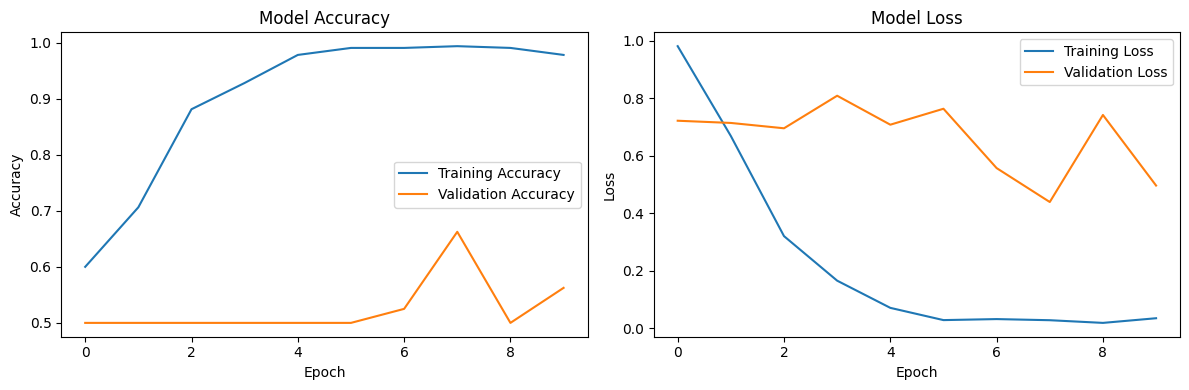

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicted Class: with_mask
Confidence: 100.00%


In [7]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np
import os
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

class MedicalMaskClassifier:
    def __init__(self, img_height=224, img_width=224, num_classes=2):
        """
        Medical Mask Classification Model with Synthetic Data Generation

        Args:
            img_height (int): Input image height
            img_width (int): Input image width
            num_classes (int): Number of classification classes
        """
        self.img_height = img_height
        self.img_width = img_width
        self.num_classes = num_classes
        self.model = None

    def generate_synthetic_dataset(self, total_samples=400, dataset_dir='medical_mask_dataset'):
        """
        Generate a synthetic dataset for testing when no real dataset is available

        Args:
            total_samples (int): Total number of synthetic images to generate
            dataset_dir (str): Directory to save synthetic dataset

        Returns:
            str: Path to generated dataset
        """
        # Create dataset directories
        os.makedirs(dataset_dir, exist_ok=True)
        classes = ['with_mask', 'without_mask']

        for cls in classes:
            class_dir = os.path.join(dataset_dir, cls)
            os.makedirs(class_dir, exist_ok=True)

        # Generate synthetic images
        for cls in classes:
            class_dir = os.path.join(dataset_dir, cls)
            for i in range(total_samples // 2):
                # Create a random color image with some structure
                noise_img = np.random.rand(self.img_height, self.img_width, 3) * 255

                # Add some color bias to simulate different classes
                if cls == 'with_mask':
                    # Bluish tint for mask images
                    noise_img[:,:,2] *= 0.7  # Reduce red channel
                else:
                    # Reddish tint for non-mask images
                    noise_img[:,:,0] *= 1.3  # Increase red channel

                noise_img = noise_img.astype(np.uint8)

                # Convert to PIL Image
                pil_img = Image.fromarray(noise_img)

                # Save image
                img_path = os.path.join(class_dir, f'synthetic_{cls}_{i}.jpg')
                pil_img.save(img_path)

        print(f"Synthetic dataset created at {dataset_dir}")
        return dataset_dir

    def build_transfer_model(self, fine_tune=True):
        """
        Build transfer learning model using VGG16

        Args:
            fine_tune (bool): Whether to fine-tune lower layers
        """
        # Load pre-trained VGG16 model
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(self.img_height, self.img_width, 3)
        )

        # Fine-tuning strategy
        if fine_tune:
            # Unfreeze last few layers
            for layer in base_model.layers[-4:]:
                layer.trainable = True

            # Freeze earlier layers
            for layer in base_model.layers[:-4]:
                layer.trainable = False
        else:
            # Completely freeze base model
            for layer in base_model.layers:
                layer.trainable = False

        # Advanced classification head
        x = base_model.output
        x = GlobalAveragePooling2D()(x)

        # Sophisticated top layers
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)

        # Output layer
        output = Dense(self.num_classes, activation='softmax')(x)

        # Create final model
        self.model = Model(inputs=base_model.input, outputs=output)

        # Advanced compilation
        optimizer = Adam(learning_rate=1e-4)
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def prepare_data(self, train_dir=None, batch_size=32):
        """
        Prepare data generators

        Args:
            train_dir (str, optional): Directory with training images
            batch_size (int): Batch size for training
        """
        # If no training directory provided or doesn't exist, generate synthetic data
        if train_dir is None or not os.path.exists(train_dir):
            print("No valid dataset found. Generating synthetic dataset...")
            train_dir = self.generate_synthetic_dataset()

        # Advanced data augmentation
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.2
        )

        # Training data generator
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(self.img_height, self.img_width),
            batch_size=batch_size,
            class_mode='categorical',
            subset='training'
        )

        # Validation data generator
        val_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(self.img_height, self.img_width),
            batch_size=batch_size,
            class_mode='categorical',
            subset='validation'
        )

        return train_generator, val_generator

    def train_model(self, train_generator, val_generator, epochs=10):
        """
        Train the model

        Args:
            train_generator: Training data generator
            val_generator: Validation data generator
            epochs (int): Number of training epochs
        """
        if self.model is None:
            self.build_transfer_model()

        # Train the model
        history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator
        )

        return history

    def predict_image(self, image_url, class_names=None):
        """
        Predict class of image from URL

        Args:
            image_url (str): URL of image to classify
            class_names (list): List of class names

        Returns:
            Prediction results
        """
        if self.model is None:
            raise ValueError("Model not trained. Build and train the model first.")

        try:
            # Download image
            response = requests.get(image_url)
            img = Image.open(BytesIO(response.content))

            # Resize and convert to RGB
            img = img.resize((self.img_height, self.img_width))
            img = img.convert('RGB')

            # Convert to array and preprocess
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Make prediction
            predictions = self.model.predict(img_array)
            predicted_class = np.argmax(predictions, axis=1)[0]
            confidence = predictions[0][predicted_class]

            # Get class name if provided
            class_name = (class_names[predicted_class]
                          if class_names and predicted_class < len(class_names)
                          else f"Class {predicted_class}")

            return {
                'class': class_name,
                'confidence': float(confidence)
            }

        except Exception as e:
            print(f"Error loading or predicting image: {e}")
            return None

def main():
    # Initialize the classifier
    classifier = MedicalMaskClassifier()

    # Build the model
    model = classifier.build_transfer_model()

    # Prepare data (will generate synthetic data if no path provided)
    train_generator, val_generator = classifier.prepare_data()

    # Print class information
    print("\nClass Labels:")
    for cls, idx in train_generator.class_indices.items():
        print(f"{cls}: {idx}")

    # Train the model
    history = classifier.train_model(
        train_generator,
        val_generator,
        epochs=10
    )

    # Visualize training history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Example image classification
    image_url = "https://na.cx/i/eqzQJYw.jpg"

    # Predict
    result = classifier.predict_image(image_url, list(train_generator.class_indices.keys()))

    if result:
        print(f"Predicted Class: {result['class']}")
        print(f"Confidence: {result['confidence']:.2%}")

if __name__ == "__main__":
    main()

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import requests
from PIL import Image
import numpy as np
from io import BytesIO

# Load VGG16 model and prepare it for transfer learning
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base layers

    # Add custom layers for binary classification
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Prepare the dataset
def load_data(data_dir):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split=0.2
    )

    train_data = datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )

    val_data = datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )

    return train_data, val_data

# Preprocess an image from URL
def preprocess_image(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).resize((224, 224))
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Test image classification
def test_image(image_url, model, class_names):
    img = preprocess_image(image_url)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])
    return class_names[predicted_class]

# Main flow for Google Colab
if __name__ == "__main__":
    # Step 1: Build the model
    model = build_model()

    # Step 2: Load and prepare the dataset
    # Update this path to point to the uploaded dataset in Colab
    data_dir = "/content/medical_mask_dataset"  # Dataset should be uploaded here
    if not os.path.exists(data_dir):
        print("Dataset directory not found! Please upload your dataset as a .zip file.")
        print("Example: Upload 'medical_mask_dataset.zip' and unzip it.")
        exit()

    train_data, val_data = load_data(data_dir)

    # Step 3: Train the model
    model.fit(train_data, validation_data=val_data, epochs=50)

    # Save the trained model
    model.save("medical_mask_classifier.h5")
    print("Model trained and saved!")

    # Step 4: Test with an image from a URL
    class_names = list(train_data.class_indices.keys())  # Extract class names from the dataset
    image_url = input("Enter an image URL (e.g., https://na.cx/i/eqzQJYw.jpg): ")
    try:
        result = test_image(image_url, model, class_names)
        print(f"Predicted Class: {result}")
    except Exception as e:
        print(f"Error during image classification: {e}")

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step - accuracy: 0.4789 - loss: 2.3011 - val_accuracy: 0.5000 - val_loss: 0.7248
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.4928 - loss: 0.7376 - val_accuracy: 1.0000 - val_loss: 0.6749
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.6543 - loss: 0.6698 - val_accuracy: 0.6250 - val_loss: 0.6620
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.6590 - loss: 0.6549 - val_accuracy: 0.7625 - val_loss: 0.6468
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.6372 - loss: 0.6391 - val_accuracy: 1.0000 - val_loss: 0.6242
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.8127 - loss: 0.6128 - val_accuracy: 0.9875 - val_loss: 0.5937
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.7494 - loss: 0.6000 - val_accuracy: 1.0000 - val_loss: 0.5601
Epoch 8/50
10/10 ━━━━━━

Model trained and saved!
Enter an image URL (e.g., https://na.cx/i/eqzQJYw.jpg): https://na.cx/i/eqzQJYw.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Predicted Class: with_mask


In [6]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import requests
from PIL import Image
import numpy as np
from io import BytesIO

# Load VGG16 model and prepare it for transfer learning
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base layers

    # Add custom layers for binary classification
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Prepare the dataset
def load_data(data_dir):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split=0.2
    )

    train_data = datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )

    val_data = datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )

    return train_data, val_data

# Preprocess an image from URL
def preprocess_image(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).resize((224, 224))
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Test image classification
def test_image(image_url, model, class_names):
    img = preprocess_image(image_url)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])
    return class_names[predicted_class]

# Main flow
def main():
    # Step 1: Build the model
    model = build_model()

    # Step 2: Load and prepare the dataset
    data_dir = "/content/medical_mask_dataset"
    if not os.path.exists(data_dir):
        print(f"The directory {data_dir} does not exist. Please upload and extract your dataset to this location.")
        return

    train_data, val_data = load_data(data_dir)

    # Step 3: Train the model
    model.fit(train_data, validation_data=val_data, epochs=5)

    # Save the trained model
    model.save("medical_mask_classifier.h5")
    print("Model trained and saved!")

    # Step 4: Test with an image from a URL
    class_names = list(train_data.class_indices.keys())  # Extract class names from the dataset
    image_url = input("Enter an image URL (e.g., https://na.cx/i/eqzQJYw.jpg): ")
    try:
        result = test_image(image_url, model, class_names)
        print(f"Predicted Class: {result}")
    except Exception as e:
        print(f"Error during image classification: {e}")

if __name__ == "__main__":
    main()


Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - accuracy: 0.5325 - loss: 1.7710 - val_accuracy: 0.5000 - val_loss: 0.6803
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.5125 - loss: 0.7747 - val_accuracy: 0.5125 - val_loss: 0.6435
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.6776 - loss: 0.6320 - val_accuracy: 1.0000 - val_loss: 0.6102
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.7827 - loss: 0.5972 - val_accuracy: 1.0000 - val_loss: 0.5699
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.7064 - loss: 0.5820 - val_accuracy: 1.0000 - val_loss: 0.5342


Model trained and saved!
Enter an image URL (e.g., https://na.cx/i/eqzQJYw.jpg): https://na.cx/i/eqzQJYw.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
Predicted Class: with_mask
